In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

#### Set Embeddings

In [4]:
emb = OpenAIEmbeddings()

#### Docs to index

In [5]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

#### Load

In [6]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

#### Split

In [7]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

#### Add to vectorstore

In [8]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=emb,
)
retriever = vectorstore.as_retriever()

## LLMs

In [9]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages.ai import AIMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

#### Data Model

In [10]:
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question, choose to route it to web search or a vectorstore.",
    )

#### LLM with function call

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

#### Prompt

In [37]:
system = """You are responsible for accurate routing of a user question to either a vectorstore or web search.
If the question is related to the topics of AI agents, prompt engineering, and adversarial attacks, route to the vectorstore.
For any other topics, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the bears draft first in the NFL draft?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='web_search'
datasource='vectorstore'


## Retrieval Grader

#### Data Model

In [13]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

#### LLM with function call

In [14]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

#### Prompt

In [15]:
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


## Generate

In [16]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

#### Prompt

In [17]:
prompt = hub.pull("rlm/rag-prompt")

/home/longview/anaconda3/envs/langgraph/lib/python3.12/site-packages/langsmith/client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


#### LLM

In [18]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

#### Post-processing

In [19]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#### Chain

In [20]:
rag_chain = prompt | llm | StrOutputParser()

#### Run

In [21]:
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory in LLM-powered autonomous agents refers to a long-term memory module that records the agent's experiences in natural language. This memory allows agents to reflect on past events, synthesize higher-level inferences, and inform future behavior based on relevance, recency, and importance. It enhances the agent's ability to interact and make decisions in a dynamic environment.


## Hallucination Grader

#### Data Model

In [22]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

#### LLM with function call

In [23]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

#### Prompt

In [24]:
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
    Give a binary 'yes' or 'no' score. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucinations_grader = hallucination_prompt | structured_llm_grader
hallucinations_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Answer Grader

#### Data Model

In [25]:
class GradeAnswer(BaseModel):
    """Binary score to assess if answer addresses the question."""

    binary_score: str = Field(
        description="Answer addressess the question, 'yes' or 'no'"
    )

#### LLM with function call

In [26]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
structured_llm_acc_grader = llm.with_structured_output(GradeAnswer)

#### Prompt

In [27]:
system = """You are a grader assessing whether an answer addresses / resolves a question \n
    Give a binary 'yes' or 'no' score. 'Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeHallucinations(binary_score='yes')

## Question Re-writer

#### LLM

In [28]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

#### Prompt

In [29]:
system = """You are a question re-writer that converts an input question into a better version that is optimized \n
    for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.")
    ]
)

question_rewriter = re_write_prompt | llm
question_rewriter.invoke({"question": question})

AIMessage(content='What are the key concepts and techniques related to agent memory in artificial intelligence?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 69, 'total_tokens': 84, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-31ee997b-f349-4ba5-896c-ce53f8065305-0', usage_metadata={'input_tokens': 69, 'output_tokens': 15, 'total_tokens': 84})

## Web Search Tool

#### Search

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Construct the Graph

#### Define Graph State

In [70]:
from typing import List, Annotated
from typing_extensions import TypedDict

# Define the reducer function (optional if multiple nodes update the counter)
def retry_reducer(a: int, b: int | None) -> int:
    return a + (b if b is not None else 0)

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM Generation
        documents: list of documents
        retrieve_retries: track retry attempts
        max_retries: maximum retries allowed
    """

    question: str
    generation: str
    documents: List[str]
    retrieve_retries: Annotated[int, retry_reducer]
    max_retries: int

## Define Graph Flow

#### Node Functions

In [78]:
from langchain.schema import Document

def router(state):
    """
    Route question according to content and available data sources.

    Args:
        state (dict): The current graph state

    Returns:
        None : acts as a landing point for routing decisions; edge logic handles routing
    """

    print("---ROUTE---")
    pass

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    print("---RETRIEVE---")
    question = state["question"]

    # Check if question is an AIMessage and extract text
    if hasattr(question, 'content'):
        question = question.content
    elif isinstance(question, AIMessage):
        question = str(question)
    
    # Ensure question is a string
    if not isinstance(question, str):
        raise ValueError("Question must be a string after extraction.")

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Update question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Check if question is an AIMessage and extract text
    if hasattr(question, 'content'):
        question = question.content
    elif isinstance(question, AIMessage):
        question = str(question)
    
    # Ensure question is a string
    if not isinstance(question, str):
        raise ValueError("Question must be a string after extraction.")

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

#### Edge Functions

In [79]:
def route_question(state):
    """
    Route question to web search or RAG
    
    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO THE QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determine whether the generation is grounded in the document and answers the question.
    
    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucinations_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check for hallucinations
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            state["generation_failures"] = state.get("generation_failures", 0) + 1
            if state["generation_failures"] >= state["max_retries"]:
                print("---RETRY LIMIT REACHED: TERMINATING---")
                return "terminate"
            elif state["generation_failures"] % 3 == 0:
                print("---CONSECUTIVE FAILURES LIMIT REACHED: REROUTING---")
                state["fallback_message"] = "Failed to generate a proper response after several attempts. Rerouting."
                return "reroute"
            return "not useful"  # Retry or rephrase the query
    else:
        # Hallucination
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS; RE-TRY---")
        return "hallucination detected"  # Retry generation

#### Compile Graph

In [80]:
from langgraph.graph import END, StateGraph, START

In [81]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("router", router)
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# Build graph
workflow.add_edge(START, "router")
workflow.add_conditional_edges(
    "router",
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
            "transform_query": "transform_query",
            "generate": "generate",
    },
)
workflow.add_edge("transform_query", "router")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
            "hallucination detected": "generate",
            "useful": END,
            "not useful": "transform_query",
            "terminate": END,
            "reroute": "router",
    },
)

# Compile
app = workflow.compile()

## View Graph

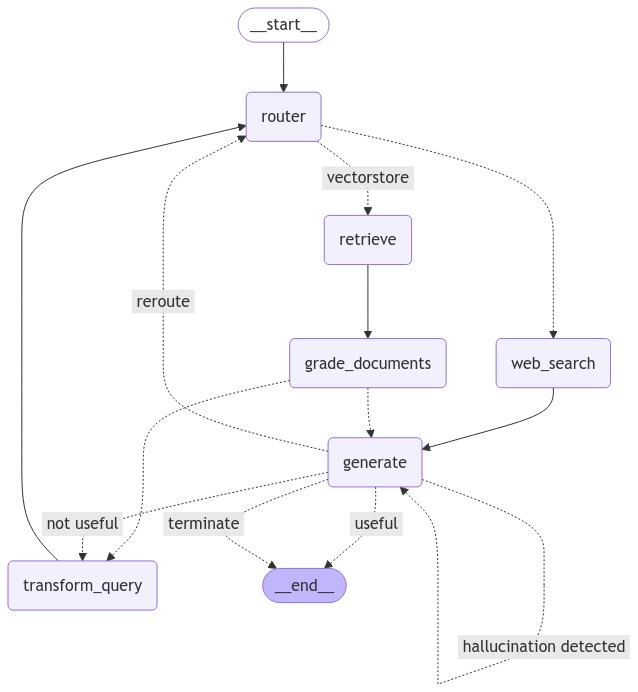

In [82]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## Use Graph

In [83]:
from pprint import pprint

# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?",
    "max_retries": 5,
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE---
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
"Node 'router':"

---

---WEB SEARCH---
"Node 'web_search':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'generate':"

---

---TRANSFORM QUERY---
"Node 'transform_query':"

---

---ROUTE---
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
"Node 'router':"

---

---WEB SEARCH---
"Node 'web_search':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"

---

('The Chicago Bears are projected to select quarterback Caleb Williams from '
 'USC with the first overall pick in the 2024 NFL Draft. This has been the '
 'consensus since they traded Justin Fields.')
